# Music Machine Learning - Support Vector Machines (SVM)

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A recap on the [motivation](#motivation) behind Support Vector Machines (SVM)
2. A simple use case for [understanding and fitting SVMs](#fitting) with the scikit library
3. Developing our own [implementation](#implem) of linear SVMs
4. An introuction to [kernels](#improve) in SVMs and how to implement them

## Support Vector Machines (SVM)

In this tutorial, we will cover a more advanced classification algorithm through the use of *Support Vector Machines* (SVMs). The goal is to gain an intuition of how SVMs works and how to use *Gaussian kernel* with SVMs to find out the decision boundary. The implementation proposed here follows a simplified version of the *Sequential Minimal Optimization* (SMO) algorithm for training support vector machines, which is detailed in the following [paper](http://cs229.stanford.edu/materials/smo.pdf). The complete SMO algorithm can then be quite easily implemented following the [full paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf).

Once again, to simplify your work, we provide the following set of functions that you should find in the `data` folder, and in the `helper_plot` file


  |**File**|*Explanation*|
  |-------:|:------------|
  |`svm_linear.mat`|Example data for a quasi-linear problem|
  |`svm_gaussian.mat`|Example data for a non-linear but well-defined problem|
  |`plot_data`|Allows to plot the set of data points|
  |`visualize_boundary`|Plots a non-linear decision boundary from a SVM model|
  |`plot_svc_decision_function`|Plots a linear decision boundary|

In [1]:
import numpy as np
from scipy import io as sio
from matplotlib import pyplot as plt
from helper_plot import plot_data, visualize_boundary, visualize_boundary_linear, hdr_plot_style, plot_svc_decision_function

<a id="motivation"></a>
## Motivation

In the previous course on neural networks, we learned how to train a simple neuron. We saw that this simple model could be interpreted as defining a line, separating the space into two different regions. This allows to consider problems of *discriminative classification*: rather than modeling each class, we simply find a line that divides the classes from each other. As an example of these _linearly separable_ problems, consider the simple case of a classification task, in which the two classes of points are well separated:

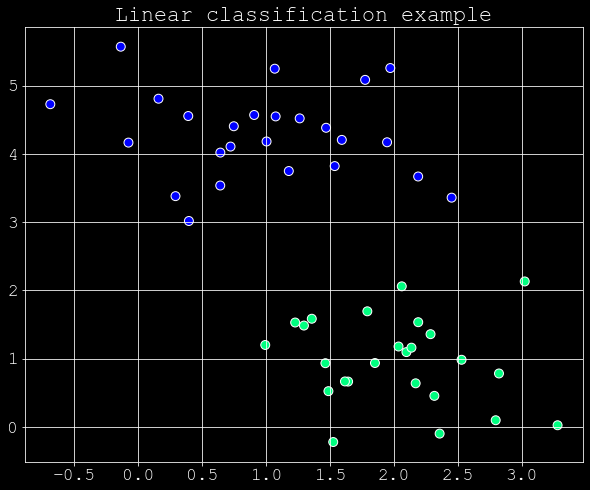

In [2]:
from sklearn.datasets import make_blobs
hdr_plot_style()
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.65)
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolor='w', cmap='winter');
plt.title("Linear classification example");

As we have seen previously, a single neuron classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification, by optimizing the parameters $\theta=\{\mathbf{w}, b\}$ of

$$

y=\sigma\left(\sum_{i = 1}^{n}w_{i}.x_{i} + b\right)


$$


For two dimensional data like that shown here, this is a task we could do by hand. But the major problem that we can directly see, is that there is an infinite number of lines that can perfectly discriminate between the two classes, as exemplified in the next example.

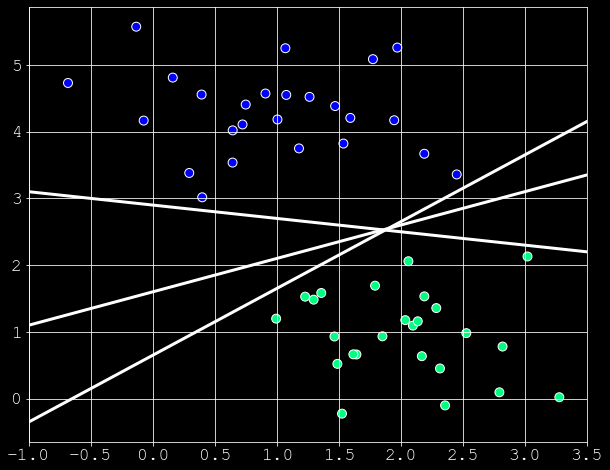

In [3]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolor='w', cmap='winter')
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-w')
plt.xlim(-1, 3.5);

Note that these solutions are all valid, and will mostly depend on the (random) initialization of our parameters. Although these all perfectly discriminate between our samples, we can clearly see that they are more or less "optimal" to the problem at hand. So our question today is how could we formalize this problem, and if we could find a formulation to adress and solve this issue.

### Notion of _margin_

The intuition behind comparing different solutions is that rather than estimating only the line between the classes, we can also look at the *margin* of some width defined around those line. In our simple case, it would look like this

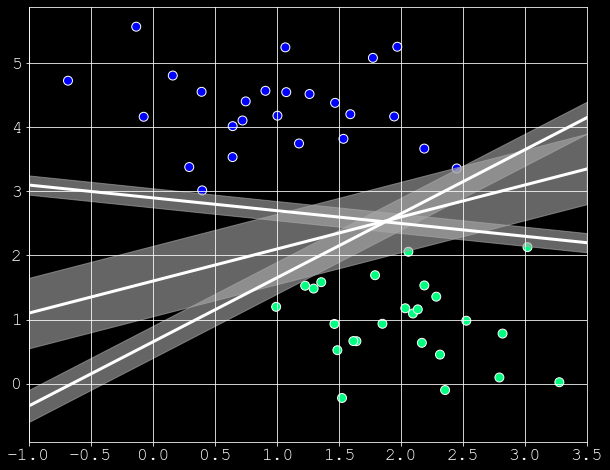

In [4]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolor='w', cmap='winter')
for m, b, d in [(1, 0.65, 0.25), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.15)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-w')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='w', color='#AAAAAA', alpha=0.6)
plt.xlim(-1, 3.5);

In *Support Vector Machines (SVMs)*, the goal is to find that optimal model, in which our separating line maximizes this margin. Hence, SVMs are part of a class of models called *maximum margin* estimator.

<a id="fitting"></a>
## Fitting a SVM

More formally the goal of SVMs is that given a set of input vectors $ \mathbf{x} $ separated in two classes (noted $ \mathbf{x}^{+} $ and $ \mathbf{x}^{-} $), we would like to find the *optimal boundary* (separating line) between the two classes. To do so, we want to find the separation that gives the *maximal margin* between the two sets. Hence, we can first define the following problem

$$
\begin{cases}
\mathbf{w}\cdot\mathbf{x}^{+}+\mathbf{b}\geq1\\
\mathbf{w}\cdot\mathbf{x}^{-}+\mathbf{b}\leq-1
\end{cases}
$$

By setting the variable $ y_{i}={+}/{-}1 $, we can rewrite this problem as 

$$

y_{i}\left(x_{i}\cdot\mathbf{w}+\mathbf{b}\right)-1\geq0

$$

The idea is that for some of the input vectors (called *support vectors*), we will have an equality in equation (1), where $ \mathbf{w}\cdot\mathbf{x}^{+}+\mathbf{b}=1 $ and $ \mathbf{w}\cdot\mathbf{x}^{-}+\mathbf{b}=-1 $. By substracting those two equation, we see that we are trying to find a solution to 

$$

\frac{\mathbf{w}}{\left\Vert \mathbf{w}\right\Vert }\cdot\left(x^{+}-x^{-}\right)=\frac{2}{\left\Vert \mathbf{w}\right\Vert }=Width

$$

Therefore, solving the set of equations amounts to find the maximal margin between the support vectors (as they *support* classification). 

### Fitting the SVM with scikit-learn

First, we can see the result of fitting this approach to our original data. To do so, we will use the SVM model found in `scikit-learn` to train an SVM model on this data. To do so, we can use the following code

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

To visualize the results, we will use our quick convenience function that plots the SVM decision boundaries

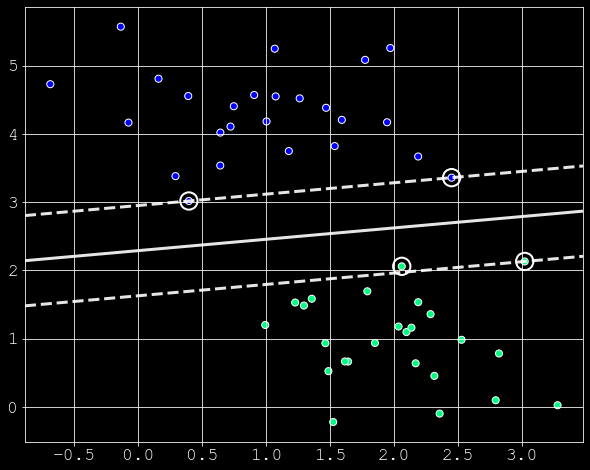

In [6]:
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='w', cmap='winter')
plot_svc_decision_function(model);

This separating line is the one that maximizes the margin between our two sets of points.
Notice that some training points are right on the margin. These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name. In `scikit-learn`, we can directly obtain the values of these points, stored in the ``support_vectors_`` attribute of the classifier:

In [7]:
model.support_vectors_

array([[0.39920934, 3.01626962],
       [2.45161058, 3.35844964],
       [2.06209253, 2.05847948],
       [3.02263145, 2.12999162]])

The major advantage of SVM is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit. Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin. We can see this, for example, if we plot the model learned from the first 50 or 150 points of this dataset

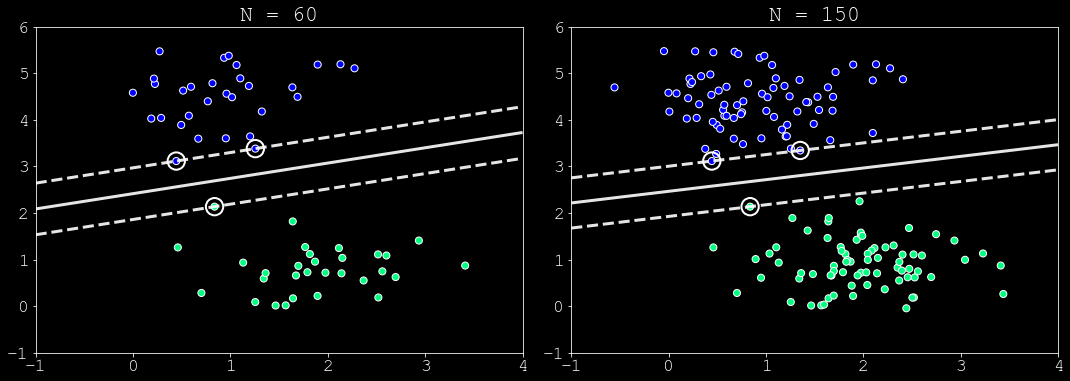

In [8]:
# Plotting SVM trained on subsampled dataset
def plot_svm_subsample(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor = 'w', cmap='winter')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 150]):
    plot_svm_subsample(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

<a id="implem"></a>
## Implementing our own linear SVM

Here, we are going to try to implement our own linear SVM. We recall that, given a set of input vectors $ \mathbf{x} $ separated in two classes ($ \mathbf{x}^{+} $ and $ \mathbf{x}^{-} $, we would like to find the *optimal boundary* (separating line) between the two classes. This means that we are trying to find a solution to 

$\frac{\mathbf{w}}{\left\Vert \mathbf{w}\right\Vert }\cdot\left(x^{+}-x^{-}\right)=\frac{2}{\left\Vert \mathbf{w}\right\Vert }=Width$

Therefore, solving the set of equations amounts to find the maximal margin between the support vectors (as they *support* classification). As seen in the slides, we know that this problem can also be expressed as  

$$f\left(x\right)=\sum_{i=1}^{m}\alpha_{i}y_{i}\left\langle \phi\left(x_{i}\right),\phi\left(x\right)\right\rangle +b$$

Where the function $\phi(.)$ will be used later to introduce _kernels_, but for now, we will consider that $\phi(x)=x$, which reduces our problem to

$$
f\left(x\right)=\sum_{i=1}^{m}\alpha_{i}y_{i}\left\langle x_{i},x \right\rangle +b
$$


we can introduce a kernel $K\left(x_{i},x\right)=\phi\left(x_{i}\right)\cdot\phi\left(x\right)$ in the equation in order to solve non-linear optimization problems. We can use this formulation to perform the *predictions* of the algorithm and in the first part of this tutorial, we will only consider the *linear* kernel $K\left(x_{i},x\right)=x_{i}\cdot x$.

Now, if we look at the way the SVM model that we trained is implemented in `scikit-learn`, we have the following variables

In [9]:
print(vars(model))

{'decision_function_shape': 'ovr', 'break_ties': False, 'kernel': 'linear', 'degree': 3, 'gamma': 'scale', 'coef0': 0.0, 'tol': 0.001, 'C': 1.0, 'nu': 0.0, 'epsilon': 0.0, 'shrinking': True, 'probability': False, 'cache_size': 200, 'class_weight': None, 'verbose': False, 'max_iter': -1, 'random_state': None, '_sparse': False, 'n_features_in_': 2, 'class_weight_': array([1., 1.]), 'classes_': array([0, 1]), '_gamma': 0.2228546804477968, 'support_': array([18, 25,  7, 46]), 'support_vectors_': array([[0.39920934, 3.01626962],
       [2.45161058, 3.35844964],
       [2.06209253, 2.05847948],
       [3.02263145, 2.12999162]]), '_n_support': array([2, 2]), 'dual_coef_': array([[-0.24571733, -0.99437155,  1.        ,  0.24008889]]), 'intercept_': array([3.45657164]), '_probA': array([], dtype=float64), '_probB': array([], dtype=float64), 'fit_status_': 0, 'shape_fit_': (50, 2), '_intercept_': array([-3.45657164]), '_dual_coef_': array([[ 0.24571733,  0.99437155, -1.        , -0.24008889]])}


For the moment, our variables of interest are
- `support_vectors_` : _Support vectors_ (dataset points that support classification)
- `dual_coef_` : The $\alpha_{i} * y_{i}$ (coefficients from the dual formulation) for the _support_vectors_
- `n_support_` : Number of support vectors for each class (ordered)
- `_intercept_` : Value of $b$ in our formulation (bias)

In order to begin our own implementation of the SVM, we are going to start by computing the _decision function_ of the model. We are going to slightly change the model structure, to better reflect the mathematical formulation than `scikit-learn`. Hence, our model structure and all of its corresponding parameters will be defined as

``` Python
model = {};
model["x"];            # Values of _support vectors_ in input data
model["y"];            # Classes labels of _support vectors_
model["n"];            # Number of support for each class
model["b"];            # Value of bias
model["alphas"];       # Value of alphas
model["kernel"];       # Type of kernel
model["w"];            # Weights of vectors in primal formulation
```  

In the following, we show how to shift from the `scikit-learn` version to ours

In [10]:
#%% Creating a fake (random) model
our_model = {};
# Values of _support vectors_ in input data
our_model["x"] = model.support_vectors_
# Corresponding classes of the support vectors
our_model["y"] = np.concatenate([[0] * model.n_support_[0], [1] * model.n_support_[1]])
# Number of vectors for each class
our_model["n"] = model.n_support_
# Value of threshold
our_model["b"] = model._intercept_            
# Values of alphas
our_model["alphas"] = model._dual_coef_[0]      
print(our_model)

{'x': array([[0.39920934, 3.01626962],
       [2.45161058, 3.35844964],
       [2.06209253, 2.05847948],
       [3.02263145, 2.12999162]]), 'y': array([0, 0, 1, 1]), 'n': array([2, 2]), 'b': array([-3.45657164]), 'alphas': array([ 0.24571733,  0.99437155, -1.        , -0.24008889])}


Computing the _predictions_ of the SVM is performed by calling `model.decision_function(X)` in `scikit_learn`. We are going to implement this behavior ourselves by coding our own `decision_function` function

``` Python
def decision_function(model, X)
    """
    % Returns a vector of predictions using a trained SVM model. 
    % model   : svm model returned from svmTrain.
    % X       : m x n matrix where each example is a row. 
    """
    return pred
```

For the time being we are using a _linear kernel_, but we might later use a different type of kernel, so we will directly use a `kernel` function which computes our kernel between the support vectors `x_s` and a dataset `X`.

***

**Exercice**
1. Implement the linear kernel function
1. Complete the decision function based on the dual formulation

***

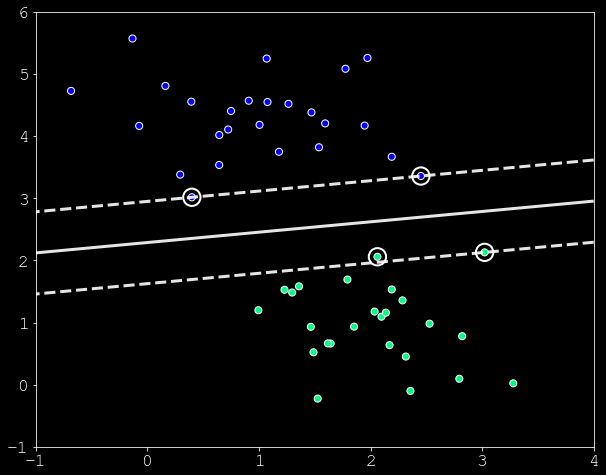

In [11]:
def kernel(x, X, type='linear'):
    if (type == 'linear'):
        k = np.dot(x,X)
    return k

# This function should replicates the scikit-learn one
def decision_function(model, X):
    
    f = np.dot(model["alphas"],kernel(model["x"],X)) + model["b"]
    #print(f)
    return f

# Evaluate the decision function
ax = plt.figure(figsize=(10,8)).gca()
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor = 'w', cmap='winter')
ax.set_xlim(-1, 4); ax.set_ylim(-1, 6)
xlim = ax.get_xlim(); ylim = ax.get_ylim()
# Create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 30)
yp = np.linspace(ylim[0], ylim[1], 30)
Y, Xp = np.meshgrid(yp, x)
xy = np.vstack([Xp.ravel(), Y.ravel()]).T
P = decision_function(our_model, xy.transpose())
P = P.reshape((30, 30))
# plot decision boundary and margins
ax.contour(Xp, Y, P, colors='w',levels=[-1, 0, 1], alpha=0.9,linestyles=['--', '-', '--']);
ax.scatter(our_model["x"][:, 0], our_model["x"][:, 1],s=300, linewidth=2, edgecolor='w', facecolors='none');

## Learning phase

In order to perform learning, we will try to maximize the *dual formulation* problem expressed as

$$
\begin{equation}
w\left(\alpha\right)=\sum_{i}\alpha_{i}-\frac{1}{2}\sum_{i}\sum_{j}y_{i}y_{j}\alpha_{i}\alpha_{j}\left\langle \phi\left(x_{i}\right),\phi\left(x_{j}\right)\right\rangle 
\end{equation}
$$

with $0\leq \alpha_{i} \leq C$ and $\sum_{i=1}^{m}{\alpha_{i} y_{i}} = 0$. $C$ is a chosen *regularization hyper-parameter*. To ease your work, we will implement only a simplified version of the SMO algorithm which is mainly focused on the optimization aspects. The SMO algorithm selects two $\alpha$ parameters, $\alpha_{i}$ and $\alpha_{j}$ and optimizes the objective value jointly for both these $\alpha_{i,j}$. Finally it adjusts the $b$ parameter based on the new $\alpha_{i,j}$. This process is repeated until the $\alpha_{i,j}$ converge.

### Selecting $\alpha$

The full SMO algorithm use heuristics to choose which $\alpha_{i}$ and $\alpha_{j}$ to optimize (which greatly increase the convergence speed. However, for this simplified version, we will simply iterate on all $\alpha_{i},i=1,\cdots ,m$ and select a random $\alpha_{j}$, to perform the joint optimization of $\alpha_{i}$ and $\alpha_{j}$

### Optimizing $\alpha_{i}$ and $\alpha_{j}$

To jointly optimize the value, we first find bounds $L$ and $H$ such that $L\leq \alpha_{j} \leq H$ holds to satisfy the constraint of the original problem $0\leq \alpha_{i} \leq C$

$$
\begin{array}{ccc}
if\text{ }y_{i}\neq y_{j}, & L=max\left(0,\alpha_{j}-\alpha_{i}\right), & H=min\left(C,C+\alpha_{j}-\alpha_{i}\right)\\
if\text{ }y_{i}=y_{j}, & L=max\left(0,\alpha_{i}+\alpha_{j}-C\right), & H=min\left(C,\alpha_{i}+\alpha_{j}\right)
\end{array}
$$

Now we want to find $\alpha_{j}$ so as to maximize the objective function. It can be shown (as in the original paper) that the optimal $\alpha_{j}$ is given by

$$
\alpha_{j}=\alpha_{j}-\frac{y_{j}\left(E_{i}-E_{j}\right)}{\eta}
$$

where

$$
\begin{array}{ccc}
E_{k} & = & f\left(x_{k}\right)-y_{k}\\
\eta & = & 2\left\langle x_{i},x_{j}\right\rangle -\left\langle x_{i},x_{i}\right\rangle -\left\langle x_{j},x_{j}\right\rangle 
\end{array}
$$

$E_{k}$ defines the error between the prediction of the SVM on the example $k$ and its desired label. When computing $\eta$, we can also replace the inner product by a kernel function $K$. Finally, we clip the value of $\alpha_{j}$ to lie within the selected bounds.

$$
\alpha_{j}=\begin{cases}
H & if\text{ }\alpha_{j}>H\\
\alpha_{j} & if\text{ }L\leq\alpha_{j}\leq H\\
L & if\text{ }\alpha_{j}<L
\end{cases}
$$

Now that we have solved $\alpha_{j}$, we can update the value for $\alpha_{i}$ through

$$
\alpha_{i}^{t}=\alpha_{i}^{t-1}+y_{i}y_{j}\left(\alpha_{j}^{(t-1)}-\alpha_{j}\right)
$$

### Computing threshold $b$

Finally, we can compute the threshold $b$ to satisfy the original constraints by selecting

$$
b=
\begin{cases}
b_{1} & if\text{ }0<\alpha_{i}<C\\
b_{2} & if\text{ }0<\alpha_{j}<C\\
\left(b_{1}+b_{2}\right)/2 & otherwise
\end{cases}
$$

where

$$
b_{1}=b-E_{i}-y_{i}\left(\alpha_{i}^{(t-1)}-\alpha_{i}\right)\left\langle x_{i},x_{i}\right\rangle -y_{j}\left(\alpha_{j}^{(t-1)}-\alpha_{j}\right)\left\langle x_{i},x_{j}\right\rangle   
$$
$$
b_{2}=b-E_{i}-y_{i}\left(\alpha_{i}^{(t-1)}-\alpha_{i}\right)\left\langle x_{i},x_{j}\right\rangle -y_{j}\left(\alpha_{j}^{(t-1)}-\alpha_{j}\right)\left\langle x_{j},x_{j}\right\rangle 
$$

For the first part of this tutorial, we will compute the main iterations of the algorithm (minimization of the objective function), while relying on a *linear* kernel. This implies that we will only be able to perform linear discrimination. However, remember that the formulation of the SVMs provide an *optimal* and (gloriously) *convex* answer to this problem.

```Python
def svm_train(X, Y, C, kernelFunction, tol, maxIter):
    """
    % Trains an SVM classifier using a simplified SMO algorithm. 
    % X       : m x n matrix of m training examples (with n-dimensional features).
    % Y       : column vector of class identifiers
    % C       : standard SVM regularization parameter
    % tol     : tolerance value used for determining equality of floating point numbers. 
    % maxIter : number of iterations over the dataset before the algorithm stops.
    """
    return model
```

***

**Exercise**  
<div markdown="1">  

  1. Update the `svm_train` code to perform the training of a SVM with linear kernel.
  2. Run your `svm_train` function on our linear dataset to obtain similar results as `scikit-learn`
  3. Update the framework to display the decision boundary at each iteration of the algorithm.
  
***

Training Linear SVM ...
Training ...
 Done !


<ipython-input-13-01b1e5130a55>:123: UserWarning: No contour levels were found within the data range.
  ax.contour(Xp, Y, P, colors='w',levels=[-1, 0, 1], alpha=0.9,linestyles=['--', '-', '--'])


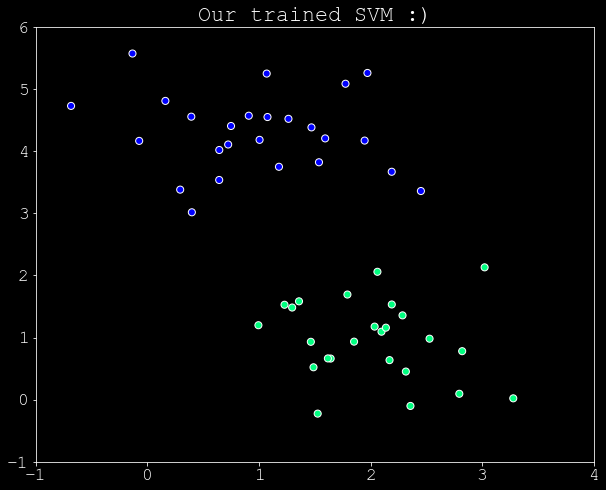

In [13]:
from base64 import b16decode
from binascii import b2a_base64


def svm_train(X, Y_b, C, kernel_type, tol=1e-3, max_iter=5):
    """
    SVMTRAIN Trains an SVM classifier using a simplified version of the SMO 
    # X       : m x n matrix of m training examples (with n-dimensional features).
    # Y       : column vector of class identifiers (0 or 1)
    # C       : standard SVM regularization parameter
    # tol     : tolerance value used for determining equality of floating point numbers. 
    # maxIter : number of iterations over the dataset before the algorithm stops.
    """
    # Data parameters
    m, n = X.shape
    # Variables
    alphas = np.zeros((m, 1))
    b, passes, eta, L, H = 0, 0, 0, 0, 0
    E = np.zeros((m, 1))
    Y = Y_b.copy()
    Y[Y == 0] = -1
    
    # Pre-compute the kernel matrix (in practice, the optimized packages will _not_ do this)
    K = np.array(kernel(X, X.transpose(), kernel_type))

    
    # Train
    print('Training ...')
    while passes < max_iter:
        # Check that some alphas changed
        num_changed_alphas = 0;
        # Iterative over all alpha_i
        for i in range(m):
            #E = np.dot(alphas*Y,K) + b - Y
            #print(E)
            j = np.random.randint(0,m)
            while j==i:
                j = np.random.randint(0,m)
            
            E[i] = np.dot(alphas[:,0] * Y, K[i]) + b - Y[i]
            E[j] = np.dot(alphas[:,0] * Y, K[j]) + b - Y[j]
            
            if ((Y[i]*E[i] < -tol and alphas[i] < C) or (Y[i]*E[i] > tol and alphas[i] > 0)):
                
                alphasj_prev = alphas[j]
                alphasi_prev = alphas[i]
                
                
                if Y[i]==Y[j]:
                    L = max(0,alphas[i]+alphas[j]-C)
                    H = min(C,alphas[i]+alphas[j])
                else:
                    L = max(0,alphas[j]-alphas[i])
                    H = min(C,C+alphas[j]-alphas[i])
                    
                if L==H:
                    continue
                
                
                eta = 2*K[i,j]-K[i,i]-K[j,j] + 1e-9
                
                alphas[j] -= -Y[j]*(E[i]-E[j])/eta
                
                    
                if alphas[j]>H:
                    alphas[j]=H
                elif alphas[j]<L:
                    alphas[j]=L
                    
                if abs(alphasj_prev-alphas[j]) < 1e-5 :
                    continue
                
                alphas[i] = alphasi_prev + Y[i]*Y[j]*(alphasj_prev-alphas[j])
                
                b1 = b - E[i] - Y[i]*(alphasi_prev - alphas[i])*K[i,i] - Y[j]*(alphasj_prev-alphas[j])*K[i,j]
                b2 = b - E[i] - Y[i]*(alphasi_prev - alphas[i])*K[i,j] - Y[j]*(alphasj_prev-alphas[j])*K[j,j]
                
                if 0<alphas[i]<C:
                    b = b1
                elif 0<alphas[j]<C:
                    b = b2
                else :
                    b = (b1+b2)/2

                num_changed_alphas += 1   
                
        if (num_changed_alphas == 0):
            passes = passes + 1
        else: 
            passes = 0
    print(' Done !');
    # Save the model
    idx = (alphas > 0).transpose()[0];
    model = {} 
    model["x"] = X[idx, :]
    model["y"] = Y[idx]
    model["b"] = b
    model["alphas"] = alphas[idx, 0] * Y[idx]
    model["kernel"] = kernel
    return model

# Training Linear SVM 
print('Training Linear SVM ...')
# Parameters of the training
C = 1                  # C regularization value
tolerance = 1e-5       # Tolerance value for thresholds
nb_iterations = 50      # Number of iterations
# Perform the training (try to fiddle the previous values to see effect).
model = svm_train(X, y, C, 'linear', tolerance, nb_iterations);
# Evaluate the decision function
ax = plt.figure(figsize=(10, 8)).gca()
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor = 'w', cmap='winter')
ax.set_xlim(-1, 4); ax.set_ylim(-1, 6)
xlim = ax.get_xlim(); ylim = ax.get_ylim()
# Create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 30)
yp = np.linspace(ylim[0], ylim[1], 30)
Y, Xp = np.meshgrid(yp, x)
xy = np.vstack([Xp.ravel(), Y.ravel()]).T
P = decision_function(model, xy.transpose())
P = P.reshape((30, 30))
# plot decision boundary and margins
ax.contour(Xp, Y, P, colors='w',levels=[-1, 0, 1], alpha=0.9,linestyles=['--', '-', '--'])
ax.scatter(model["x"][:, 0], model["x"][:, 1],s=300, linewidth=2, edgecolor='w', facecolors='none');
plt.title('Our trained SVM :)');

# Beyond linear problems with _kernels_

For the time being, our SVM is only able to solve _linear_ problems. However, the SVM approach becomes truly powerful is when it is combined with *kernels*. As seen in the slides, the major idea is to project our (non-linearly separable) data into a higher-dimensional space, where it becomes linearly separable (allowing to fit for nonlinear relationships with a linear classifier).

To better understand this idea, we can look at the same non linearly separable data that we discussed in the slides. Here, we try to fit a _linear_ SVM to this non-linear problem.

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='w', cmap='winter')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data. As discussed, we need to think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient. For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle group of points.

In [ ]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot

In [ ]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    plt.figure(figsize=(10, 8));
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, edgecolor='w', cmap='winter')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
plot_3D(elev=30, azim=-50, X=X, y=y);

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane. Here we had to choose and carefully tune our projection. In general, the need to make such a choice is a problem, as we would like to somehow automatically find the best basis functions to use. One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm find the result. This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between **each pair of points**.

To see this idea in action first, we will (as previously) use `scikit-learn`, where we can apply _kernelized SVM_ simply by changing our _linear kernel_ to an _RBF (radial basis function)_ kernel, using the ``kernel`` model hyperparameter:

In [ ]:
model = SVC(kernel='rbf', C=1E6)
model.fit(X, y)

Once fitted, we can see that our SVM is able to find the largest margin between these two sets of data

In [ ]:
plt.figure(figsize=(10, 8)); plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='w', cmap='winter')
plot_svc_decision_function(model)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

## Implementing the gaussian kernel

As we have seen previously, we know that the complete SVM optimization problem can also be expressed as  

$$
\begin{equation}
f\left(x\right)=\sum_{i=1}^{m}\alpha_{i}y_{i}\left\langle \phi\left(x_{i}\right),\phi\left(x\right)\right\rangle +b
\end{equation}
$$

where we can introduce the kernel $K\left(x_{i},x\right)=\phi\left(x_{i}\right)\cdot\phi\left(x\right)$ in the equation in order to solve non-linear optimization problems. We can use this formulation to perform the *predictions* of the algorithm. Consequently, the complete *dual formulation* problem expressed as

$$
\begin{equation}
w\left(\alpha\right)=\sum_{i}\alpha_{i}-\frac{1}{2}\sum_{i}\sum_{j}y_{i}y_{j}\alpha_{i}\alpha_{j}\left\langle \phi\left(x_{i}\right),\phi\left(x_{j}\right)\right\rangle 
\end{equation}
$$

with $0\leq \alpha_{i} \leq C$ and $\sum_{i=1}^{m}{\alpha_{i} y_{i}} = 0$. The Gaussian kernel (also called *Radial Basis Function (RBF)* kernel) allows to perform the optimization of non-linear classification problems. It is defined as  

$$
K\left(x,y\right)=exp\left(\frac{-\left\Vert x-y\right\Vert ^{2}}{\left(2\sigma^{2}\right)}\right)
$$

As seen in the slides, the underlying idea is that instead of trying to solve a non-linear separation problem in a given space, we might first transform the space into a target space in which the problem is linearly separable. Therefore, we transform the space through a kernel (which is directly expressed in the minimization problem) and solve the linear separation problem in the target space. Given the starter code and the previous exercise, you should be able to directly plug this kernel inside the `svmTrain` and `svmPredict` functions.

***

**Exercise**  

  1. Update the `kernel` function code to be able to rely on a Gaussian kernel.
  2. Check that you can run the `decision_function` code to rely on this Gaussian kernel.
  2. Run the `svm_train` function on our new (non-linear) dataset to obtain similar results as `scikit-learn`
  3. Once again, display the decision boundary at each iteration of the algorithm.

***

In [ ]:
def kernel(x, X, type='linear'):
    #sigma = 1 # ?
    l=0
    if (type == 'linear'):
        l = np.dot(x,X)
    elif kernel == 'gaussian':
        l = np.exp(-np.dot(x-X,x-X)/(2*sigma**2))
    return l


plt.title('Traning Dataset')
# Parameters of the training
C = 1                  # C regularization value
tolerance = 1e-3       # Tolerance value for thresholds
nb_iterations = 20     # Number of iterations
sigma = 0.1            # Variance of Gaussian kernel
# Train the SVM with a Gaussian (RBF) kernel
model = svm_train(X, y, C, 'gaussian', tolerance, nb_iterations) 
# Evaluate the decision function
ax = plt.figure(figsize=(10, 8)).gca()
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor = 'w', cmap='winter')
ax.set_xlim(-1, 4); ax.set_ylim(-1, 6)
xlim = ax.get_xlim(); ylim = ax.get_ylim()
# Create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 30)
yp = np.linspace(ylim[0], ylim[1], 30)
Y, Xp = np.meshgrid(yp, x)
xy = np.vstack([Xp.ravel(), Y.ravel()]).T
P = decision_function(model, xy.transpose())
P = P.reshape((30, 30))
# plot decision boundary and margins
ax.contour(Xp, Y, P, colors='w',levels=[-1, 0, 1], alpha=0.9,linestyles=['--', '-', '--'])
ax.scatter(model["x"][:, 0], model["x"][:, 1],s=300, linewidth=2, edgecolor='w', facecolors='none');
plt.title('Our trained SVM :)');

## Supplementary kernels (optionnel à partir de là)

Now that you have mastered the concept of kernels and updated your code to include the Gaussian kernel, you can augment your classifier and optimizaton problem to include several different kernels as those proposed afterwards.

#### Polynomial kernel.

Intuitively, the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these. 

$$
K\left(x,y\right)=\left(x^{T}y+1\right)^{d}
$$

#### Sigmoid (tanh) kernel.

This kernel takes two parameters: $a$ and $r$. For $a > 0$, we can view $a$ as a scaling parameter of the input data, and $r$ as a shifting parameter that controls the threshold of mapping. For $a < 0$, the dot-product of the input data is not only scaled but reversed.

$$
K\left(x,y\right)=tanh\left(kx^{T}y+\Theta\right)
$$

***

**Exercise**  

  1. Update the `kernel` function code to include these supplementary kernels.
  2. Test both the `decision_function` and `svm_train` codes for these new kernels.

***

## Audio application

As seen in the previous tutorial, we have considered only a *binary classification* problem (where elements can only belong to one of two classes). This simplifies the work as we simply need to separate the space between two types of points. However, in real-world problems, we usually want to solve *multi-class* problems with any given number of classes. For this tutorial, we will rely on a simple trick which is to consider that a $n$-class problem can simply be restated as $n$ different binary classification problems. The underlying idea is that each class defines a binary classifier which tells us if a given element is part of this class, or belongs to *any of the other* classes.

***

**Exercise**  

  1. Change the training loop to define $n$separate binary problems
  2. For each problem, train an SVM to perform classification.
  3. Evaluate the global classification accuracy of your system.
  
***

In [ ]:
from helper_data import import_dataset, compute_transforms, compute_features
class_path = 'data/classification'
# 0.1 - Import the classification dataset
data_struct = import_dataset(class_path, 'classification')
# 0.2 - Pre-process the audio to obtain spectral transforms 
data_struct = compute_transforms(data_struct)
# 0.3 - Compute a set of temporal and spectral features
data_struct = compute_features(data_struct)